In [20]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import cPickle as pkl
import datetime
REF=datetime.datetime.now().strftime ("%Y%m%d")
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
import matplotlib
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Read input file

In [20]:
inp_file= pd.read_csv("./train_indessa.csv")
inp_file.columns
inp_file.describe()



,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
count,5.324280e+05,532428.000000,532428.000000,532428.000000,532428.000000,5.324250e+05,532428.000000,532412.000000,532412.000000,259874.000000,82123.000000,532412.000000,532412.000000,5.324280e+05,532141.000000,532412.000000,532428.000000,532428.000000,532428.000000,532428.000000,532333.000000,132980.000000,532412.000000,490424.000000,4.904240e+05,4.904240e+05,532428.000000
mean,3.500547e+07,14757.595722,14744.271291,14704.926696,13.242969,7.502984e+04,18.138767,0.314448,0.694603,34.055735,70.093068,11.545594,0.194858,1.692128e+04,55.057189,25.267357,1753.428788,0.394954,45.717832,4.859221,0.014299,44.121462,0.005015,213.562222,1.395541e+05,3.208057e+04,0.236327
std,2.412148e+07,8434.420080,8429.139277,8441.290381,4.379611,6.519985e+04,8.369074,0.860045,0.997025,21.884797,28.139219,5.311442,0.583822,2.242322e+04,23.853436,11.843211,2093.199837,4.091546,409.647467,63.123361,0.133005,22.198410,0.079117,1958.571538,1.539149e+05,3.805304e+04,0.424826
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,1.200000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.086688e+07,8000.000000,8000.000000,8000.000000,9.990000,4.500000e+04,11.930000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.444000e+03,37.700000,17.000000,441.600000,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,2.983975e+04,1.400000e+04,0.000000
50%,3.709590e+07,13000.000000,13000.000000,13000.000000,12.990000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187600e+04,56.000000,24.000000,1072.690000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,8.066950e+04,2.370000e+04,0.000000
75%,5.848920e+07,20000.000000,20000.000000,20000.000000,16.200000,9.000000e+04,23.950000,0.000000,1.000000,50.000000,92.000000,14.000000,0.000000,2.084300e+04,73.600000,32.000000,2234.735000,0.000000,0.000000,0.000000,0.000000,61.000000,0.000000,0.000000,2.084792e+05,3.980000e+04,0.000000
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,9.500000e+06,672.520000,30.000000,31.000000,180.000000,121.000000,90.000000,86.000000,2.568995e+06,892.300000,162.000000,24205.620000,358.680000,33520.270000,7002.190000,16.000000,180.000000,14.000000,496651.000000,8.000078e+06,9.999999e+06,1.000000


# Preprocess

In [21]:
text_cols= ['title', 'desc' ]
hidden_numeric=['term','emp_length','zip_code','last_week_pay']
categorical=['batch_enrolled','grade','sub_grade','emp_title','home_ownership','verification_status','pymnt_plan','purpose','addr_state','initial_list_status','application_type']

# Cleanup

In [23]:

inp_file_bak=inp_file
inp_file[categorical]=inp_file[categorical].replace('', np.nan, regex=True)
inp_file[categorical]=inp_file[categorical].replace(' ', np.nan, regex=True)
for column in categorical:
    inp_file[column].fillna(inp_file[column].mode()[0], inplace=True)



In [24]:
cat_pickle='categorical_processed_'+ REF + '.pkl'
inp_file.to_pickle(cat_pickle)

In [18]:
inp_file= pd.read_pickle("./categorical_processed.pkl")

# 1-hot encoded from Categorical

In [4]:
inp_dummies= pd.get_dummies(inp_file, columns=categorical, drop_first=True)
# inp_dummies= pd.read_pickle("./categorical_processed.pkl")[:100000]
inp_dummies[:10]
inp_df_numeric_cols=inp_dummies.select_dtypes(include=[np.number])
y=inp_df_numeric_cols['loan_status'].values
X=inp_df_numeric_cols.drop(['loan_status', 'member_id'], 1).values

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,BAT2252229,19.19,E,E3,clerk,9 years,OWN,28700.0,Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Teacher,< 1 year,MORTGAGE,65000.0,Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Teacher,10+ years,RENT,105000.0,Verified,n,> My goal is to obtain a loan to pay off my high credit cards and get out of debt within 3 years.<br>,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,Teacher,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0
5,10247268,15000,15000,14950.0,36 months,BAT2575549,8.90,A,A5,Teacher,2 years,MORTGAGE,120000.0,Verified,n,"> We are requesting this loan to help re-organize our finances after having a tumultuous year that resulted in unexpected medical bills. I have been in the same line of work for over five years and have been at my current company, which is very stable in the marketplace, for two and a half years.<br>",debt_consolidation,Credit Card Debt Consolidation,461xx,IN,12.30,0.0,0.0,56.0,NaN,18.0,0.0,19040.0,64.5,30.0,f,1957.24,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,113th week,0.0,0.0,350619.0,29500.0,0
6,8089625,5000,5000,4975.0,36 months,BAT2252229,7.90,A,A4,Teacher,5 years,RENT,75000.0,Verified,n,> Funds will be used to pay off a debt. I am also a lender as well here on LC.<br>,debt_consolidation,PAY THEM OFF,913xx,CA,5.70,0.0,0.0,NaN,105.0,13.0,2.0,13272.0,23.9,23.0,f,578.36,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,117th week,0.0,1023.0,13272.0,55500.0,1
7,23043116,6000,6000,6000.0,36 months,BAT2252229,9.17,B,B1,Banker,8 years,MORTGAGE,54000.0,Verified,n,NaN,credit_card,Credit card refinancing,351xx,AL,11.63,0.0,1.0,46.0,NaN,13.0,0.0,3484.0,29.5,49.0,f,637.51,0.0,0.0,0.0,0.0,54.0,INDIVIDUAL,NaN,78th week,0.0,0.0,272579.0,11800.0,0
8,45900933,6000,6000,6000.0,36 months,BAT4136152,13.99,C,C4,LVN,7 years,MORTGAGE,92000.0,Verified,n,NaN,home_improvement,Home improvement,917xx,CA,30.85,0.0,0.0,77.0,NaN,16.0,0.0,47567.0,76.6,27.0,w,621.72,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,44th week,0.0,0.0,281521.0,62100.0,0
9,41272507,34550,34550,34550.0,60 months,BAT4694572,17.14,D,D4,Teacher,2 years,MORTGAGE,72000.0,Verified,n,NaN,debt_consolidation,Debt consolidation,427xx,KY,33.92,0.0,0.0,NaN,NaN,12.0,0.0,30040.0,90.5,30.0,w,5535.46,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,52th week,0.0,0.0,76034.0,33200.0,0


# TF IDF

In [26]:
v = TfidfVectorizer()
title_fill_na= inp_file['title'].fillna('')
title_tf_idf = v.fit_transform(title_fill_na[:100000])


<1x3899 sparse matrix of type '<type 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

# Test train split

In [48]:
seed = 7132
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Accuracy without tfidf features

In [49]:

# fit model to training data
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.93%


# Accuracy with tfidf features

In [50]:
X = np.hstack([title_tf_idf.toarray(), X])
seed = 7132
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# fit model to training data
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.26%


In [51]:
from sklearn import metrics
y_pred = model.predict_proba(X_test)
y_pred0= [x[1] for x in y_pred]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred0)
metrics.auc(fpr, tpr)

0.80025090610988625

# AUC

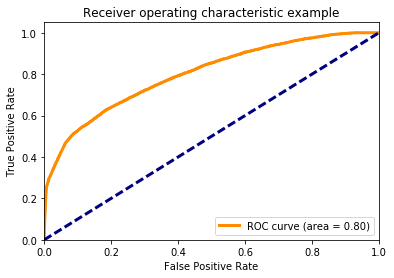

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()